#  IN3050/IN4050 Mandatory Assignment 1: Traveling Salesman Problem


## Rules
Before you begin the exercise, review the rules at this website:
https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html
(This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers
with others.)

Especially, notice that you are **not allowed to use code or parts of code written by others** in your submission. We do check your code against online repositories, so please be sure to **write all the code yourself**. Read also the "Routines for handling suspicion of cheating and attempted cheating at the University of Oslo": https://www.uio.no/english/studies/examinations/cheating/index.html By submitting this assignment, you confirm that you are familiar with the rules and the consequences of breaking them.

### Delivery

**Deadline**: Friday, February 28 2025, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

## What to deliver?

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which includes:
* PDF report containing:
    * Your name and username (!)
    * Instructions on how to run your program, with example runs.
    * Answers to all questions from assignment.
    * Brief explanation of what you’ve done.
    * *Your PDF may be generated by exporting your Jupyter Notebook to PDF, if you have answered all questions in your notebook*
* Source code
    * Source code may be delivered as jupyter notebooks or python files (.py)
* The european cities file so the program will run right away.
* Any files needed for the group teacher to easily run your program on IFI linux machines.

**Important**: 
* Include example runs of your code by doing the reports described in the tasks. Simply implementing the code, but never running it will not give many points.
* Include the code that was used to make all reports. Do not include reports of performance and time without also including the code that was used to produce it.
* If you weren’t able to finish the assignment, use the PDF report to elaborate on what you’ve tried
and what problems you encountered. Students who have made an effort and attempted all parts of the assignment
will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.

## Introduction
In this exercise, you will attempt to solve an instance of the traveling salesman problem (TSP) using different
methods. The goal is to become familiar with evolutionary algorithms and to appreciate their effectiveness on a
difficult search problem. You have to use Python to solve the assignment. You must write
your program from scratch (but you may use non-EA-related libraries).


|  &nbsp;   | Barcelona | Belgrade |  Berlin | Brussels | Bucharest | Budapest |
|:---------:|:---------:|:--------:|:-------:|:--------:|:---------:|:--------:|
| Barcelona |     0     |  1528.13 | 1497.61 |  1062.89 |  1968.42  |  1498.79 |
|  Belgrade |  1528.13  |     0    |  999.25 |  1372.59 |   447.34  |  316.41  |
|   Berlin  |  1497.61  |  999.25  |    0    |  651.62  |  1293.40  |  1293.40 |
|  Brussels |  1062.89  |  1372.59 |  651.62 |     0    |  1769.69  |  1131.52 |
| Bucharest |  1968.42  |  447.34  | 1293.40 |  1769.69 |     0     |  639.77  |
|  Budapest |  1498.79  |  316.41  | 1293.40 |  1131.52 |   639.77  |     0    |


<center>Figure 1: First 6 cities from csv file.</center>


## Problem
The traveling salesman, wishing to disturb the residents of the major cities in some region of the world in
the shortest time possible, is faced with the problem of finding the shortest tour among the cities. A tour
is a path that starts in one city, visits all of the other cities, and then returns to the starting point. The
relevant pieces of information, then, are the cities and the distances between them. In this instance of the
TSP, a number of European cities are to be visited. Their relative distances are given in the data file, *european_cities.csv*, found in the zip file with the mandatory assignment.

(You will use permutations to represent tours in your programs. The **itertools** module in Python provides
a permutations function that returns successive permutations, this is useful for exhaustive search)

## Helper code for visualizing solutions

Here follows some helper code that you can use to visualize the plans you generate. These visualizations can **help you check if you are making sensible tours or not**. The optimization algoritms below should hopefully find relatively nice looking tours, but perhaps with a few visible inefficiencies.

In [63]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(57)
#Map of Europe
europe_map = plt.imread('map.png')

#Lists of city coordinates
city_coords = {
    "Barcelona": [2.154007, 41.390205], "Belgrade": [20.46, 44.79], "Berlin": [13.40, 52.52], 
    "Brussels": [4.35, 50.85], "Bucharest": [26.10, 44.44], "Budapest": [19.04, 47.50],
    "Copenhagen": [12.57, 55.68], "Dublin": [-6.27, 53.35], "Hamburg": [9.99, 53.55], 
    "Istanbul": [28.98, 41.02], "Kyiv": [30.52, 50.45], "London": [-0.12, 51.51], 
    "Madrid": [-3.70, 40.42], "Milan": [9.19, 45.46], "Moscow": [37.62, 55.75],
    "Munich": [11.58, 48.14], "Paris": [2.35, 48.86], "Prague": [14.42, 50.07],
    "Rome": [12.50, 41.90], "Saint Petersburg": [30.31, 59.94], "Sofia": [23.32, 42.70],
    "Stockholm": [18.06, 60.33], "Vienna": [16.36, 48.21], "Warsaw": [21.02, 52.24]}


In [64]:
#Helper code for plotting plans
#First, visualizing the cities.
import csv
with open("european_cities.csv", "r") as f:
    data = list(csv.reader(f, delimiter=';'))
    cities = data[0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

# Map (long, lat) to (x, y) for plotting
for city, location in city_coords.items():
    x, y = (location[0], location[1])
    plt.plot(x, y, 'ok', markersize=5)
    plt.text(x, y, city, fontsize=12)


In [65]:
#A method you can use to plot your plan on the map.
def plot_plan(city_order):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(europe_map, extent=[-14.56, 38.43, 37.697 + 0.3, 64.344 + 2.0], aspect="auto")

    # Map (long, lat) to (x, y) for plotting
    for index in range(len(city_order) - 1):
        current_city_coords = city_coords[city_order[index]]
        next_city_coords = city_coords[city_order[index+1]]
        x, y = current_city_coords[0], current_city_coords[1]
        #Plotting a line to the next city
        next_x, next_y = next_city_coords[0], next_city_coords[1]
        plt.plot([x, next_x], [y, next_y])

        plt.plot(x, y, 'ok', markersize=5)
        plt.text(x, y, index, fontsize=12)
    #Finally, plotting from last to first city
    first_city_coords = city_coords[city_order[0]]
    first_x, first_y = first_city_coords[0], first_city_coords[1]
    plt.plot([next_x, first_x], [next_y, first_y])
    #Plotting a marker and index for the final city
    plt.plot(next_x, next_y, 'ok', markersize=5)
    plt.text(next_x, next_y, index+1, fontsize=12)
    plt.show()


['Barcelona', 'Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin', 'Hamburg', 'Istanbul', 'Kyiv', 'London', 'Madrid', 'Milan', 'Moscow', 'Munich', 'Paris', 'Prague', 'Rome', 'Saint Petersburg', 'Sofia', 'Stockholm', 'Vienna', 'Warsaw']


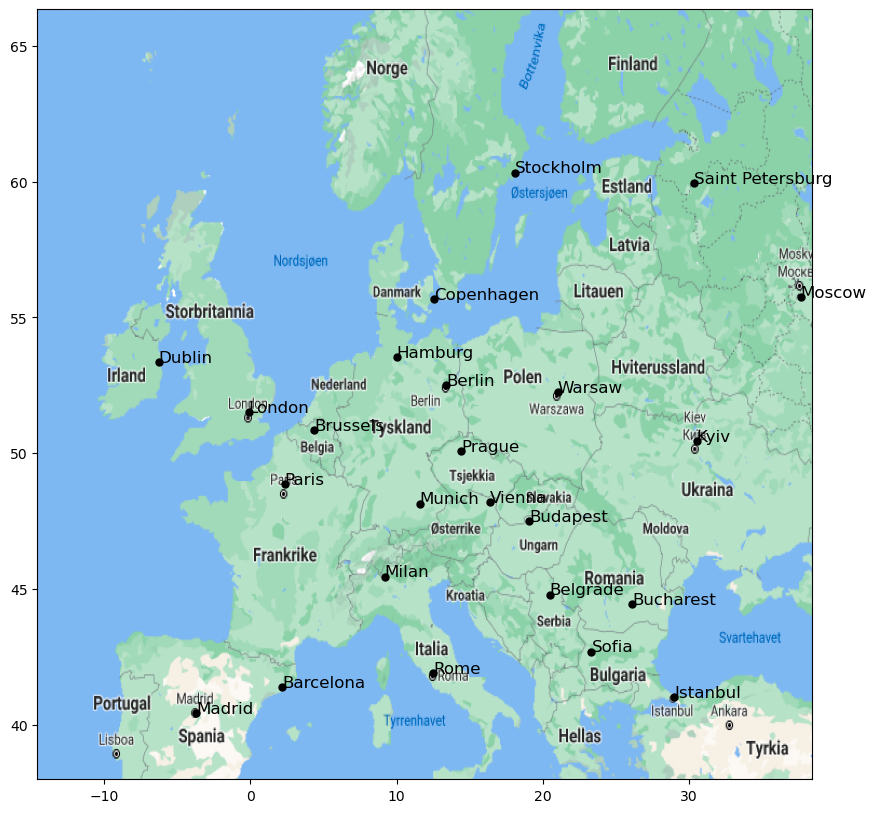

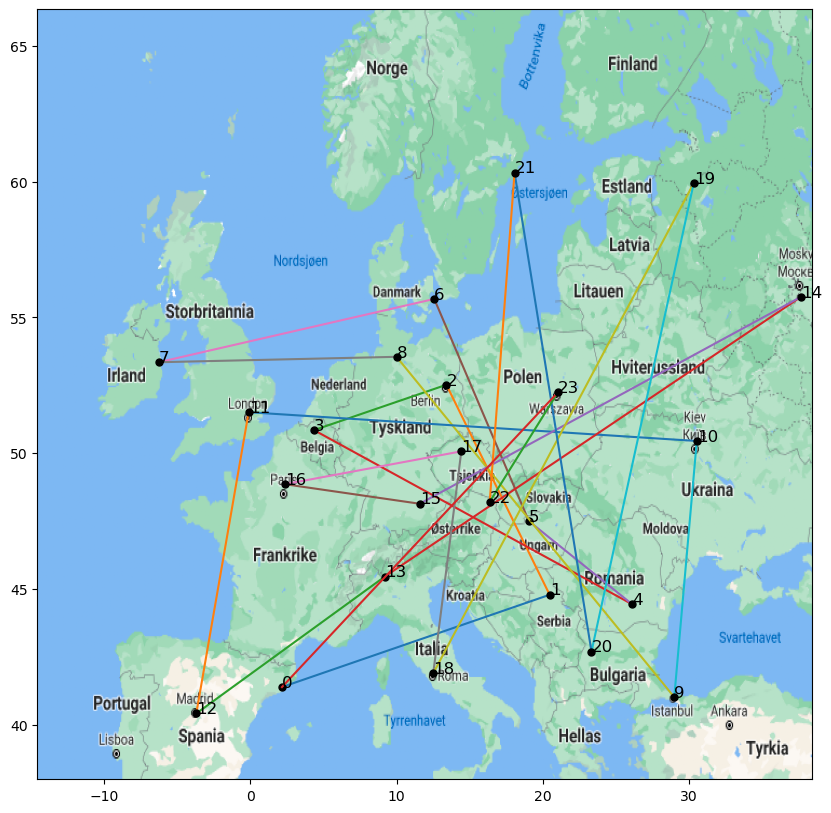

In [66]:
#Example usage of the plotting-method.
plan = list(city_coords.keys()) # Gives us the cities in alphabetic order
print(plan)
plot_plan(plan)

## Exhaustive Search
First, try to solve the problem by inspecting every possible tour. Start by writing a program to find the shortest
tour among a subset of the cities (say, **6** of them). Measure the amount of time your program takes. Incrementally
add more cities and observe how the time increases. Plot the shortest tours you found using the plot_plan method above, for 6 and 10 cities.

**Note:** To get distances between cities, use the dictionary `data` created by reading the file `european_cities.csv`. *Do not* calculate distances based on the coordinates. The actual distances do not only depend on the differences in the coordinates, but also of the curvature of the earth. The distances available in `data` are corrected for this, and contain the actual true distances.

In [67]:
from itertools import permutations
from time import time
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np 
from scipy.optimize import curve_fit

In [68]:
# Implement the algorithm here

def city_dist(city1: str, city2: str) -> float:
    """
    Calculate the distance between two cities.
    
    Parameters
    ----------
    city1 : str
        The name of the first city.
    city2 : str
        The name of the second city.
    
    Returns
    -------
    float
        The distance between the two cities.
    
    Raises
    ------
    AssertionError
        If either city1 or city2 is not in the list of cities.
    """

    assert city1 in cities, f"City {city1} not in list of cities"
    assert city2 in cities, f"City {city2} not in list of cities"
    
    col = data[0].index(city1)
    row = data[0].index(city2) + 1 # +1 because the first row is the list of cities
    
    return float(data[row][col])

def total_distance(cities: list[str]) -> float:
    """
    Calculate the total distance of a path through a list of cities.
    The function computes the total distance by summing up the distances 
    between consecutive cities in the list, including the distance from 
    the last city back to the first city.
    
    Parameters
    ----------
    cities : list of str
        A list of city names representing the path.
    
    Returns
    -------
    float
        The total distance of the path through the cities.
    """
    
    n = len(cities)
    s = city_dist(cities[0], cities[-1])
    # Summing up the distances between consecutive cities
    s += sum([city_dist(cities[i], cities[i+1]) for i in range(n-1)])
    return s

def shortest_path(cities: list[str]) -> tuple[list[str], float]:
    """
    Finds the shortest path that visits all cities and returns to the starting city.
    Parameters
    ----------
    cities : list of str
        A list of city names to visit.
    Returns
    -------
    tuple of (list of str, float)
        A tuple containing the shortest path (as a list of city names) and the total distance of that path.
    """
    
    # Use normal order as first guess
    shortest_path = cities 
    shortest_distance = total_distance(cities) 

    # Loop through all permutations of the cities
    for perm in permutations(cities):
        perm_distance = total_distance(perm) 
        if perm_distance < shortest_distance:
            shortest_distance = perm_distance
            shortest_path = perm

    return shortest_path, shortest_distance

### First 6 cities

Shortest path: Barcelona -> Brussels -> Berlin -> Budapest -> Bucharest -> Belgrade
Shortest distance:  5.02e+03 km
Execution time: 1.38e-03 seconds


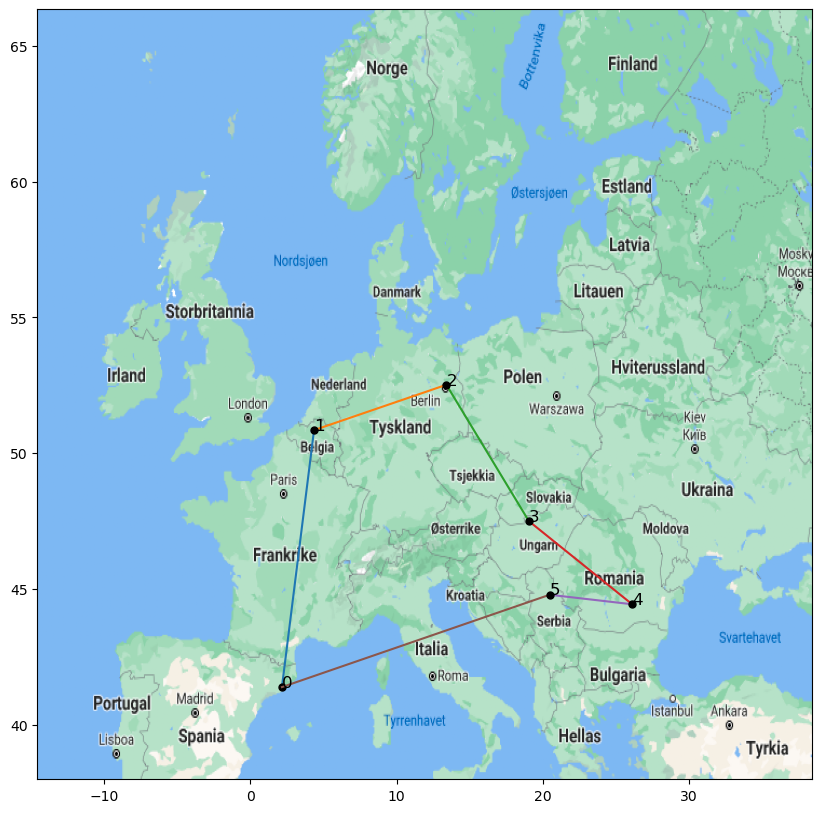

In [69]:
cities = data[0][:6]
start = time()
path, dist = shortest_path(cities)
end = time()

print(f"Shortest path: {' -> '.join(path)}")
print(f"Shortest distance: {dist: .2e} km")
print(f"Execution time: {end-start:.2e} seconds")

plot_plan(path)

### First 10 cities

What is the shortest tour (i.e., the actual sequence of cities, and its length) among the first 10 cities (that is,
the cities starting with B,C,D,H and I)? How long did your program take to find it? Calculate an approximation of how long it would take to perform exhaustive search on all 24 cities?

Shortest path: Belgrade -> Barcelona -> Dublin -> Brussels -> Hamburg -> Copenhagen -> Berlin -> Budapest -> Bucharest -> Istanbul
Shortest distance:  7.49e+03 km
Execution time: 7.87e+00 seconds


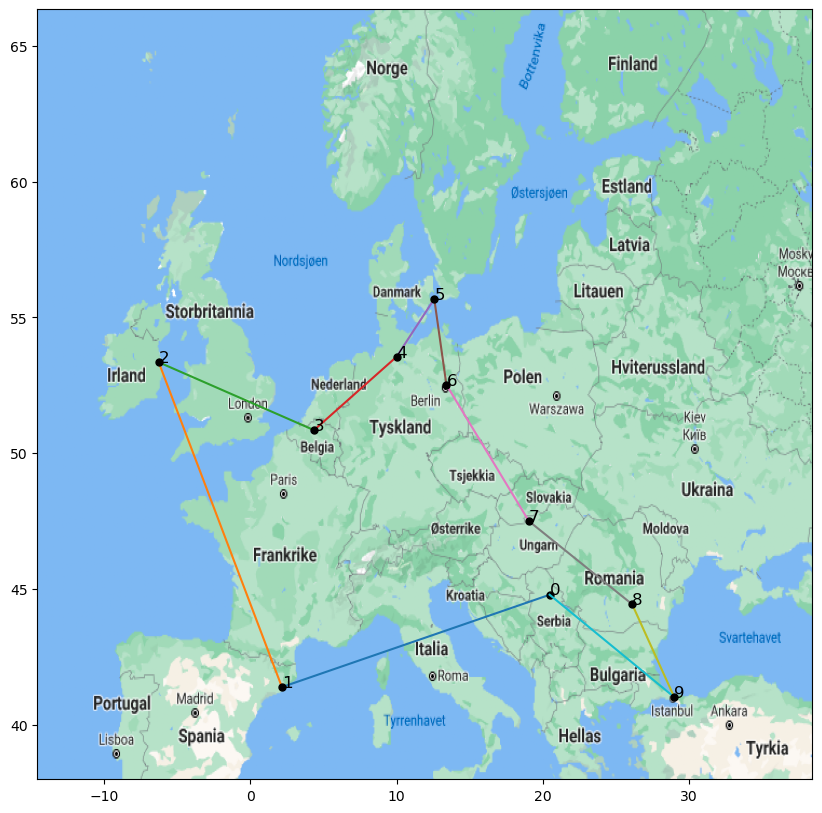

In [70]:
# Answer
cities = data[0][:10]
start = time()
path, dist = shortest_path(cities)
end = time()

print(f"Shortest path: {' -> '.join(path)}")
print(f"Shortest distance: {dist: .2e} km")
print(f"Execution time: {end-start:.2e} seconds")

plot_plan(path)

### Plotting time as a function of the number of cities

In [71]:
times = []
n_min = 6
n_max = 10

for n in range(n_min, n_max+1):
    cities = data[0][:n]
    start = time()
    _, dist = shortest_path(cities)
    end = time()
    times.append(end-start)

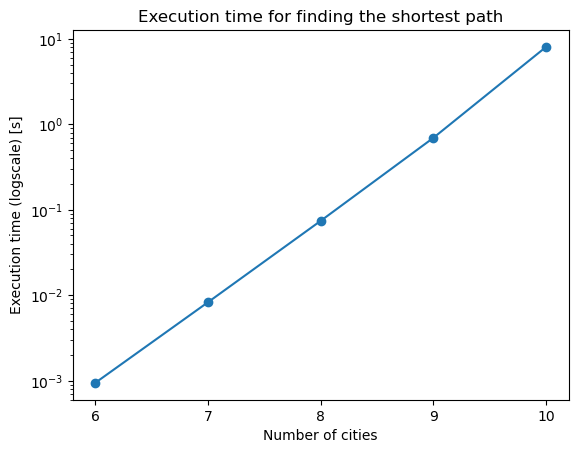

In [72]:
plt.semilogy(range(n_min, n_max+1), times, 'o-')
plt.xlabel("Number of cities")
plt.ylabel("Execution time (logscale) [s]")
plt.title("Execution time for finding the shortest path")
plt.xticks(range(n_min, n_max+1))
plt.show()

#### Extrapolation

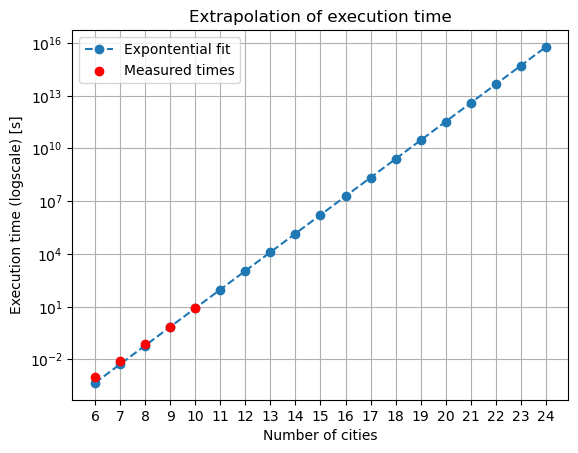

In [73]:
a, b = curve_fit(lambda x, a, b: a * np.exp(b * x), range(n_min, n_max+1), times)[0]

expansion = 25
x_fit = np.arange(n_min, 25)
x_orig = range(n_min, n_max+1)

plt.semilogy(x_fit, a * np.exp(b * x_fit), '--o', label=f"Expontential fit")
plt.scatter(x_orig, times, label="Measured times", color="red", zorder=3)
plt.xlabel("Number of cities")
plt.ylabel("Execution time (logscale) [s]")
plt.title("Extrapolation of execution time")
plt.xticks(range(n_min, expansion))
plt.grid()
plt.legend()
plt.show()

### Conclusion
As seen in the plot above, the execution time (assuming an exponential growth) leads to a runtime of $\approx10^{16}$ hours

## Hill Climbing
Then, write a simple hill climber to solve the TSP. How well does the hill climber perform, compared to the result from the exhaustive search for the first **10 cities**? Since you are dealing with a stochastic algorithm, you
should run the algorithm several times to measure its performance. Report the length of the tour of the best,
worst and mean of 20 runs (with random starting tours), as well as the standard deviation of the runs, both with the **10 first cities**, and with all **24 cities**. Plot one of the the plans from the 20 runs for both 10 cities and 24 cities (you can use plot_plan). 

In [74]:
# Implement the algorithm here


## Genetic Algorithm
Next, write a genetic algorithm (GA) to solve the problem. Choose mutation and crossover operators that are appropriate for the problem (see chapter 4.5 of the Eiben and Smith textbook). Choose three different values for the population size. Define and tune other parameters yourself and make assumptions as necessary (and report them, of course).

For all three variants: As with the hill climber, report best, worst, mean and standard deviation of tour length out of 20 runs of the algorithm (of the best individual of last generation). Also, find and plot the average fitness of the best fit individual in each generation (average across runs), and include a figure with all three curves in the same plot in the report. This means that the x-axis should be the generations over time and the y-axis should be the average (over the 20-runs) fitness of the best gene in that generation. Conclude which is best in terms of tour length and number of generations of evolution time.

Finally, plot an example optimized tour (the best of the final generation) for the three different population sizes, using the plot_plan method.

In [75]:
# Implement the algorithm here

Among the first 10 cities, did your GA find the shortest tour (as found by the exhaustive search)? Did it come close? 

For both 10 and 24 cities: How did the running time of your GA compare to that of the exhaustive search? 

How many tours were inspected by your GA as compared to by the exhaustive search?

In [76]:
# Answer

## Hybrid Algorithm (IN4050 only)
### Lamarckian
Lamarck, 1809: Traits acquired in parents’ lifetimes can be inherited by offspring. In general the algorithms are referred to as Lamarckian if the result of the local search stage replaces the individual in the population.
### Baldwinian
Baldwin effect suggests a mechanism whereby evolutionary progress can be guided towards favourable adaptation without the changes in individual's fitness arising from learning or development being reflected in changed genetic characteristics. In general the algorithms are referred to as Baldwinian if the original member is kept, but has as its fitness the value belonging to the outcome of the local search process.


(See chapter 10 and 10.2.1 from Eiben and Smith textbook for more details. It will also be lectured in Lecure 3)

### Task
Implement a hybrid algorithm to solve the TSP: Couple your GA and hill climber by running the hill climber a number of iterations on each individual in the population as part of the evaluation. Test both Lamarckian and Baldwinian learning models and report the results of both variants in the same way as with the pure GA (min,
max, mean and standard deviation of the end result and an averaged generational plot). How do the results compare to that of the pure GA, considering the number of evaluations done?

In [77]:
# Implement algorithm here